<a href="https://colab.research.google.com/github/Maheshtanni/WESAD/blob/main/WESAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!rm -rf /content/WESAD
!unzip -q "/content/drive/MyDrive/Wesad_data_set.zip" -d /content/WESAD
print("Dataset extracted.")


Mounted at /content/drive
Dataset extracted.


In [ ]:
import os, pickle, numpy as np, pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score, confusion_matrix
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from scipy.stats import wilcoxon
import shap
import matplotlib.pyplot as plt


In [ ]:
SUBJECTS = ["S2","S3","S4","S5","S6","S7",
            "S8","S9","S10","S11","S13","S14",
            "S15","S16","S17"]

def find_subject_root(root="/content/WESAD"):
    for path, dirs, files in os.walk(root):
        if all(s in dirs for s in ["S2","S3","S4"]):
            return path
    raise RuntimeError("Subject root not found")

PKL_DIR = find_subject_root()

def load_subject(sub):
    with open(os.path.join(PKL_DIR, sub, f"{sub}.pkl"), "rb") as f:
        data = pickle.load(f, encoding="latin1")
    return data["signal"], np.array(data["label"])


In [ ]:
FS_PPG, FS_ACC, FS_TEMP = 64, 32, 4
WIN_SEC = 30

def bandpass(sig, low, high, fs):
    b,a = butter(4, [low/(0.5*fs), high/(0.5*fs)], btype="band")
    return filtfilt(b,a,sig)

def segment(sig, win):
    return np.array([sig[i:i+win] for i in range(0,len(sig)-win+1,win)])

def hrv(ppg):
    peaks,_ = find_peaks(ppg, distance=int(0.5*FS_PPG))
    if len(peaks) < 3: return [0,0,0]
    rr = np.diff(peaks)/FS_PPG
    return [np.sqrt(np.mean(np.diff(rr)**2)), np.std(rr), 60/np.mean(rr)]

def wrist_features(ppg, acc, temp):
    f=[]
    f += hrv(ppg)
    mag = np.linalg.norm(acc, axis=1)
    f += [mag.mean(), mag.std()]
    f += list(acc.mean(axis=0)) + list(acc.std(axis=0))
    f += [temp.mean(), temp[-1]-temp[0], temp.var()]
    f += [ppg.mean(), ppg.var(), stats.entropy(np.abs(ppg)+1e-6)]
    return f

def build_wrist(sub):
    sig, lbl = load_subject(sub)
    ppg = bandpass(np.ravel(sig["wrist"]["BVP"]), 0.5, 5, FS_PPG)
    acc = sig["wrist"]["ACC"]
    temp = np.ravel(sig["wrist"]["TEMP"])

    ppg_w = segment(ppg, FS_PPG*WIN_SEC)
    acc_w = segment(acc, FS_ACC*WIN_SEC)
    tmp_w = segment(temp, FS_TEMP*WIN_SEC)

    lbl_w = segment(lbl, int(len(lbl)/len(ppg_w)))

    X,y=[],[]
    for i in range(len(ppg_w)):
        X.append(wrist_features(ppg_w[i], acc_w[i], tmp_w[i]))
        y.append(1 if np.sum(lbl_w[i]==2)>np.sum(lbl_w[i]!=2) else 0)

    return np.array(X), np.array(y)


In [ ]:
FS_CHEST = 700
WIN_SEC = 5
STEP_SEC = 2.5

WIN = int(FS_CHEST * WIN_SEC)
STEP = int(FS_CHEST * STEP_SEC)


def slide(sig):
    sig = np.ravel(sig)   # enforce 1-D
    return [sig[i:i+WIN] for i in range(0, len(sig)-WIN+1, STEP)]

def chest_features(ecg, resp, eda, temp):
    peaks,_ = find_peaks(ecg, distance=int(0.3*FS_CHEST))
    rr = np.diff(peaks)/FS_CHEST if len(peaks)>2 else [0]
    return [
        60/np.mean(rr) if np.mean(rr)>0 else 0,
        np.std(rr),
        eda.mean(), eda.std(),
        temp.mean(), temp[-1]-temp[0]
    ]

def build_chest(sub):
    sig,lbl = load_subject(sub)
    ecg  = np.ravel(sig["chest"]["ECG"])
    resp = np.ravel(sig["chest"]["Resp"])
    eda  = np.ravel(sig["chest"]["EDA"])
    temp = np.ravel(sig["chest"]["Temp"])



    X,y=[],[]
    for e,r,d,t,l in zip(slide(ecg),slide(resp),slide(eda),slide(temp),slide(lbl)):
        X.append(chest_features(e,r,d,t))
        y.append(1 if np.sum(l==2)>np.sum(l!=2) else 0)

    return np.array(X), np.array(y)


In [ ]:
def loso_eval(builder):
    f1s, conf = {}, np.zeros((2,2))
    y_true_all, y_pred_all, y_prob_all = [], [], []

    for test in SUBJECTS:
        Xtr,Ytr,Xte,Yte=[],[],None,None
        for s in SUBJECTS:
            X,y = builder(s)
            if s==test:
                Xte,Yte=X,y
            else:
                Xtr.append(X); Ytr.append(y)

        Xtr,Ytr = np.vstack(Xtr), np.hstack(Ytr)
        sc = StandardScaler()
        Xtr,Xte = sc.fit_transform(Xtr), sc.transform(Xte)

        sel = SelectKBest(f_classif,k=min(20,Xtr.shape[1]))
        Xtr,Xte = sel.fit_transform(Xtr,Ytr), sel.transform(Xte)

        Xtr,Ytr = SMOTE().fit_resample(Xtr,Ytr)

        clf = XGBClassifier(
            n_estimators=400, max_depth=6,
            learning_rate=0.05, subsample=0.9,
            colsample_bytree=0.9, eval_metric="logloss"
        )
        clf.fit(Xtr,Ytr)

        pred = clf.predict(Xte)
        prob = clf.predict_proba(Xte)[:,1]

        f1s[test] = f1_score(Yte,pred)
        conf += confusion_matrix(Yte,pred)

        y_true_all += list(Yte)
        y_pred_all += list(pred)
        y_prob_all += list(prob)

    return f1s, conf, y_true_all, y_pred_all, y_prob_all, clf


In [ ]:
wrist_f1, wrist_cm, yT_w, yP_w, yPr_w, wrist_clf = loso_eval(build_wrist)
chest_f1, chest_cm, _, _, _, _ = loso_eval(build_chest)


In [ ]:
w = np.array(list(wrist_f1.values()))
c = np.array(list(chest_f1.values()))

stat,p = wilcoxon(w,c,alternative="greater")
rbc = (np.sum(w>c)-np.sum(w<c))/len(w)

print("Wilcoxon:",stat,"p:",p,"Effect size:",rbc)


Wilcoxon: 71.0 p: 0.28070068359375 Effect size: 0.2


In [ ]:
print("Precision:", precision_score(yT_w,yP_w))
print("Recall:", recall_score(yT_w,yP_w))
print("ROC-AUC:", roc_auc_score(yT_w,yPr_w))
print("Confusion Matrix:\n", wrist_cm)


Precision: 0.40784313725490196
Recall: 0.26091319618665326
ROC-AUC: 0.796475807644957
Confusion Matrix:
 [[14619.   755.]
 [ 1473.   520.]]


In [ ]:
# Build full wrist dataset (all subjects combined)
X_all, y_all = [], []

for sub in SUBJECTS:
    X_sub, y_sub = build_wrist(sub)
    X_all.append(X_sub)
    y_all.append(y_sub)

X_all = np.vstack(X_all)
y_all = np.hstack(y_all)

print("Full wrist dataset:", X_all.shape, y_all.shape)


Full wrist dataset: (17367, 17) (17367,)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

selector = SelectKBest(f_classif, k=min(20, X_scaled.shape[1]))
X_selected = selector.fit_transform(X_scaled, y_all)

X_bal, y_bal = SMOTE().fit_resample(X_selected, y_all)

print("Balanced data:", X_bal.shape, y_bal.shape)


Balanced data: (30748, 17) (30748,)


In [ ]:
wrist_final = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42
)

wrist_final.fit(X_bal, y_bal)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
import shap
import pandas as pd
import numpy as np

explainer = shap.TreeExplainer(wrist_final)
shap_vals = explainer.shap_values(X_bal)

shap_importance = np.abs(shap_vals).mean(axis=0)

shap_df = pd.DataFrame({
    "Feature": [f"Feature_{i}" for i in range(X_bal.shape[1])],
    "Mean|SHAP|": shap_importance
}).sort_values("Mean|SHAP|", ascending=False)

print(shap_df.head(10))


       Feature  Mean|SHAP|
11  Feature_11    1.301883
7    Feature_7    1.017691
4    Feature_4    0.909895
6    Feature_6    0.890990
12  Feature_12    0.579340
5    Feature_5    0.535208
16  Feature_16    0.383448
13  Feature_13    0.378407
3    Feature_3    0.347738
9    Feature_9    0.332634


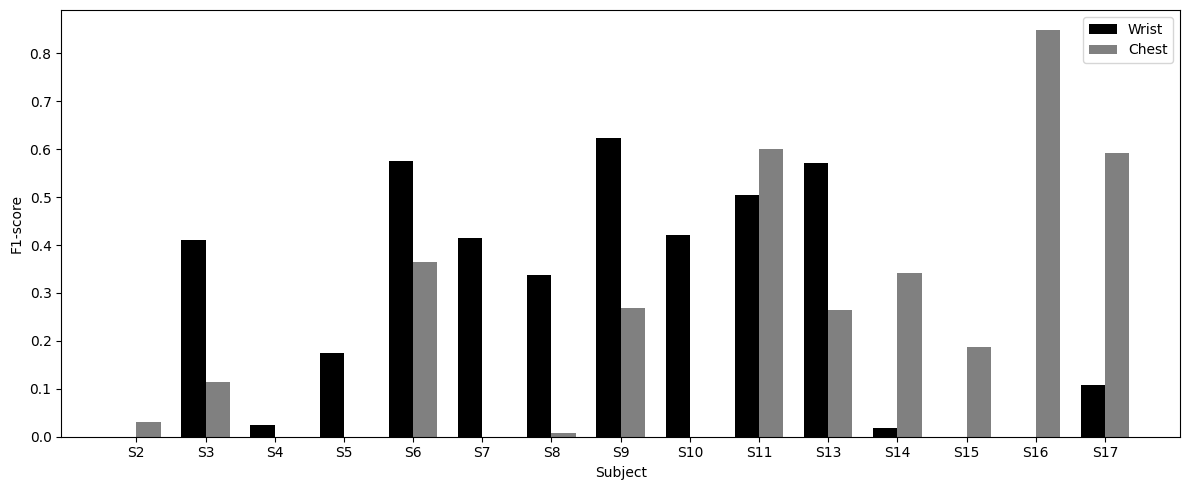

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

subjects = list(wrist_f1.keys())
w_vals = list(wrist_f1.values())
c_vals = [chest_f1[s] for s in subjects]

x = np.arange(len(subjects))
width = 0.35

plt.figure(figsize=(12,5))
plt.bar(x - width/2, w_vals, width, label="Wrist", color="black")
plt.bar(x + width/2, c_vals, width, label="Chest", color="gray")
plt.xticks(x, subjects)
plt.ylabel("F1-score")
plt.xlabel("Subject")
plt.legend()
plt.tight_layout()
plt.savefig("fig_wrist_vs_chest_f1.pdf", dpi=300)
plt.show()


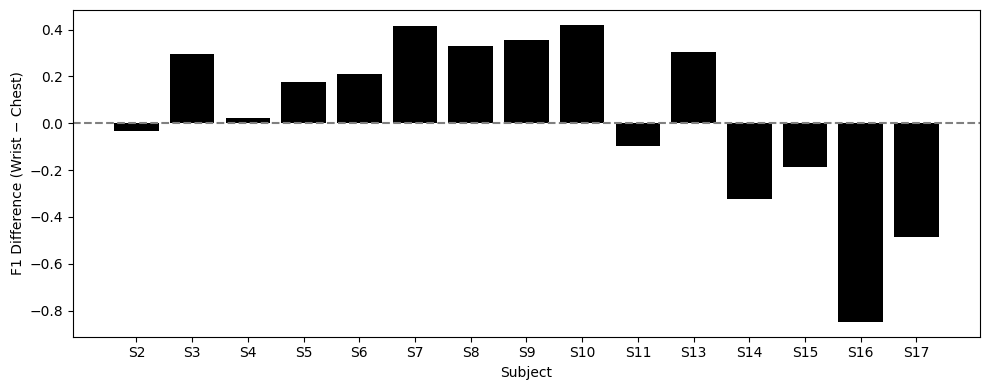

In [ ]:
diff = np.array(w_vals) - np.array(c_vals)

plt.figure(figsize=(10,4))
plt.bar(subjects, diff, color="black")
plt.axhline(0, linestyle="--", color="gray")
plt.ylabel("F1 Difference (Wrist − Chest)")
plt.xlabel("Subject")
plt.tight_layout()
plt.savefig("fig_f1_difference.pdf", dpi=300)
plt.show()


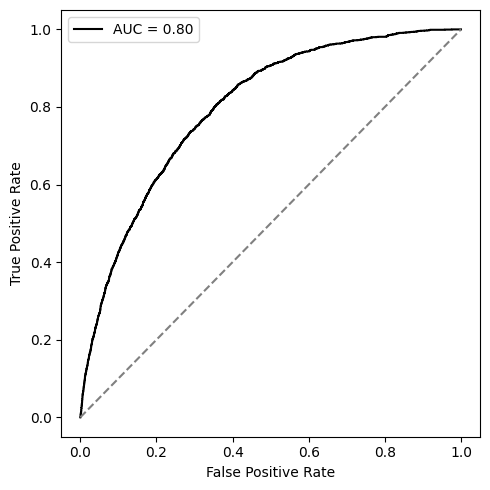

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(yT_w, yPr_w)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color="black", label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig("fig_roc_wrist.pdf", dpi=300)
plt.show()


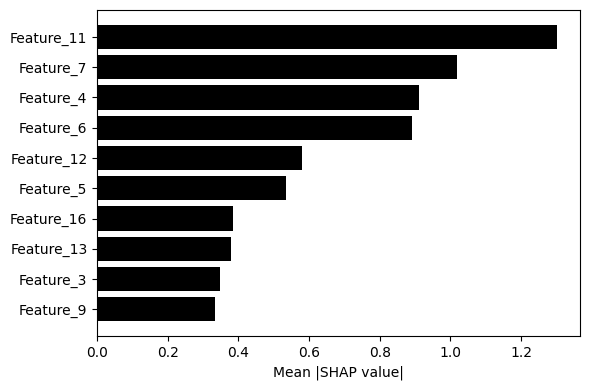

In [ ]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# SHAP on final wrist model (NOT LOSO model)
explainer = shap.TreeExplainer(wrist_final)
shap_vals = explainer.shap_values(X_bal)

# Mean absolute SHAP values
shap_importance = np.abs(shap_vals).mean(axis=0)

shap_df = pd.DataFrame({
    "Feature": [f"Feature_{i}" for i in range(X_bal.shape[1])],
    "Importance": shap_importance
}).sort_values("Importance", ascending=False).head(10)

# Plot
plt.figure(figsize=(6,4))
plt.barh(shap_df["Feature"], shap_df["Importance"], color="black")
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP value|")
plt.tight_layout()
plt.savefig("fig_shap_importance.pdf", dpi=300)
plt.show()

